In [1]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma
import scipy.linalg as linalg
import statsmodels.api as sm

# pd.set_option('max_rows', 20)
pd.set_option('max_rows', 100)

In [2]:
%%R

library(MARSS)

# Data

## Regressors

In [3]:
data = pd.read_excel("Nowcasting.xlsx",sheetname="Valores")
# data.head()
series = data.loc[0,:][~data.loc[0,:].isnull()].tolist()
data.columns = data.iloc[0]

In [4]:
# i=data.columns.get_loc("MXWO Index")
# data.iloc[1:,i:i+2]

dfsList = []

for serie in series:
    i = data.columns.get_loc(serie)
    df = data.iloc[1:,i:i+2]
    df.set_index(serie,inplace=True)
    df.columns = [serie]
    df = df.loc[~df.index.duplicated(keep='first')]
    if not df[serie].isnull().all():
        dfsList.append(df.apply(pd.to_numeric))

data = pd.concat(dfsList,axis=1)
data.sort_index(inplace=True)
if data.loc[data.index[-1]].notnull().any() == False:
    data.drop(data.index[-1],inplace=True)
data.tail()

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1877: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


,BZGDINDX Index,BZIPTLYo Index,MPMIBRMA Index,BZGDGNDI Index,BZUETOTN Index,BFOETTOD Index,BZGDFNCE Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,...,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX
2017-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66190.63,53.78,10.6000,10.9178,475.0,NaN,NaN,NaN
2017-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66033.98,53.17,10.5096,10.8762,-474.0,NaN,NaN,NaN
2017-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,64301.73,52.63,10.5724,10.8627,NaN,NaN,NaN,NaN
2017-01-31,NaN,NaN,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,79.3,64670.78,52.81,10.5262,10.8029,NaN,NaN,NaN,NaN
2017-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,65084.65,53.74,10.4928,10.8046,NaN,NaN,NaN,NaN


In [5]:
data.loc[data.index[-1]].notnull().any()

True

### Transformations


In [6]:
data.columns

Index(['BZGDINDX Index', 'BZIPTLYo Index', 'MPMIBRMA Index', 'BZGDGNDI Index',
       'BZUETOTN Index', 'BFOETTOD Index', 'BZGDFNCE Index', 'BZREELHT Index',
       'BPPICM Index', 'BZPIIPCM Index', 'BZEXTOT$ Index', 'BZTBBALY INDEX',
       'BZBXPBCM INDEX', 'BZRTFBSA INDEX', 'BZFGCCSA INDEX', 'ibov index',
       'CL1 Comdty', 'BCSWLPD CURNCY', 'bcswfpd curncy', 'BZMOTRFB INDEX',
       'BZJCGTOT INDEX', 'BZEANSA INDEX', 'OEBRD002 INDEX'],
      dtype='object')

In [7]:
transf = pd.read_excel("Nowcasting.xlsx",sheetname="Plan2",)
transf.set_index("Code",inplace=True)

In [8]:
for s in transf.index[transf["Log"]==True]:
    data[s] = data[s].apply(np.log)
    
data = data.resample("M").sum()
    
for s in transf.index[transf["Diff"]==True]:
    data[s] = data[s].diff()

for s in transf.index[transf["DiffAnnual"]==True]:
    data[s] = data[s].diff(3)

C:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1251: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [9]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

### Stationarity

In [10]:
# For now we'll drop quarterly series
data.drop("BZGDGNDI Index",axis=1,inplace=True)
data.drop("BZGDFNCE Index",axis=1,inplace=True)

In [11]:
for series in data.columns:
    try:
        d = data[series]   
        print(series)
        pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
        if pv > 0.11:
            print(series + " 's p-value is: " + str(pv))
    except:
        print("Error")

BZGDINDX Index
BZGDINDX Index 's p-value is: 0.979876753696
BZIPTLYo Index
MPMIBRMA Index
BZUETOTN Index
BZUETOTN Index 's p-value is: 0.553154193243
BFOETTOD Index
BFOETTOD Index 's p-value is: 0.938465996487
BZREELHT Index
BPPICM Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
Error
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCGTOT INDEX
BZJCGTOT INDEX 's p-value is: 0.262826717701
BZEANSA INDEX
BZEANSA INDEX 's p-value is: 0.200279351294
OEBRD002 INDEX
OEBRD002 INDEX 's p-value is: 0.52204764302


# Dimensions

In [12]:
dataQ = data[["BZGDINDX Index"]]
data.drop("BZGDINDX Index",axis=1,inplace=True)

In [13]:
T = data.shape[0]
T

206

In [14]:
n = (data.columns | dataQ.columns).shape[0]
n

21

In [15]:
nm = (data.columns).shape[0]
nm

20

In [16]:
nq = (dataQ.columns).shape[0]
nq

1

In [17]:
m = 5 + nm + 5 * nq
m

30

# Data Matrices

$y$ which is $n \times T$ will be the vertical stack of the monthly and quarterly variables

In [18]:
y = pd.concat([ data.transpose(), dataQ.transpose(),], axis=0)
y.shape

(21, 206)

# Coefficients

## Z Matrix

The $Z$ matrix is a $n \times m$

In [19]:
coefs = []
for el in data.columns:
    coefs.append(el + "_loading")
lambdaM = pd.DataFrame(coefs)

line1 = lambdaM
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,4)))], axis=1)

line1 = pd.concat([line1, pd.DataFrame(np.identity(nm))], axis=1)
missingDimension = m - line1.shape[1]
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,missingDimension)))], axis=1)

line1.shape

(20, 30)

In [20]:
coefs = []
for el in dataQ.columns:
    coefs.append(el + "_loading")
lambdaQ = pd.DataFrame(coefs)

line2 = lambdaQ
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "3*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, lambdaQ], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.zeros((nq,nm)))], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 3*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)


In [21]:
line1.columns = list(range(0,line1.columns.shape[0]))
line2.columns = list(range(0,line2.columns.shape[0]))

Z = pd.concat([line1,line2], axis=0, ignore_index=True)
Z = Z.apply(pd.to_numeric,1,errors='ignore')
Z = Z.apply(pd.to_numeric,0,errors='ignore')
Z.shape

(21, 30)

## B Matrix

$B$ matrix is $m \times m$

In [22]:
bMat = np.array(["A1",0.,0.,0.])
bMat = np.vstack((np.array(bMat),np.identity(4)))
bMat = linalg.block_diag(bMat,np.array([0]))

alphaM = "alphaM_" + pd.DataFrame(data.columns.tolist()).astype(str) 
# alphaM = alphaM.transpose()[0]
alphaM = np.diag(alphaM[0])

bMat = bMat[:-1]

bMat = linalg.block_diag(bMat,alphaM)

alphaQ = "alphaQ_" + pd.DataFrame(dataQ.columns.tolist()).astype(str) 
# alphaQ = alphaQ.transpose()[0]
alphaQ = np.diag(alphaQ[0])

bMat = linalg.block_diag(bMat,alphaQ)

newLine = np.hstack((np.zeros((nq,bMat.shape[1]-nq)),np.identity(nq)))
bMat = np.vstack((bMat,newLine))

bMat = linalg.block_diag(bMat,np.identity(m-bMat.shape[1]-1))
bMat = linalg.block_diag(bMat,np.array([0]))
bMat = bMat[:-1]
B = pd.DataFrame(bMat)
B = B.apply(pd.to_numeric,1,errors='ignore')
B = B.apply(pd.to_numeric,0,errors='ignore')
# alphaM
# newLine
# pd.to_numeric(pd.DataFrame(bMat)[0].iloc[1])
B.shape

(30, 30)

## Q Matrix

$Q_t$ is $m \times m$


In [23]:
u = np.array("u_t")
u = np.vstack((u,np.zeros((4,1))))
merrors = "em_" + pd.DataFrame(np.array([list(range(0,nm))])).astype(str)
u = np.vstack((u,merrors.T))

merrors = "eq_" + pd.DataFrame(np.array([list(range(0,nq))])).astype(str)
u = np.vstack((u,merrors.T))

u = np.vstack((u,np.zeros((m-u.shape[0],1))))

u = pd.DataFrame(u)

u[0] = pd.to_numeric(u[0],errors='ignore')

idx = np.unique(np.where(u=="0.0" )[0].tolist() + np.where(u==0 )[0].tolist())

In [24]:
Q = "Q_" + pd.DataFrame([range(0,m)]).astype(str) 
Q = Q.transpose()[0]
Q = np.diag(Q)
Q[idx] = 0
Q = pd.DataFrame(Q)
Q.shape

(30, 30)

# Estimation without initial values

In [25]:
Zi = Z.as_matrix().T.flatten()
Bi = B.as_matrix().T.flatten()
Qi = Q.as_matrix().T.flatten()
yi = y.as_matrix()

In [26]:
B.shape

(30, 30)

In [27]:
Z.shape

(21, 30)

In [28]:
y.shape

(21, 206)

In [29]:
Q.shape

(30, 30)

In [ ]:
%%R -i Zi,Bi,yi,Z,Qi,m,n


Zi=matrix(Zi,n,m)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

print(dim(Zi))
print(dim(Bi))
print(dim(Qi))


model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

kemfit = MARSS(yi, model=model.gen,control=list(maxit=50,
                                                conv.test.slope.tol=0.00001,
                                                abstol=0.00001))
# kemfit = MARSS(yi, model=model.gen)

# states = kemfit$states
states = print(kemfit, what="model")
# message(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)
# message("porra")
# states=""
# cat("teste")

In [ ]:
print(dt.datetime.now())

# Initial Values

## PCA

In [30]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(y.transpose().fillna(0))
components = pd.DataFrame(components)
# components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.5693603]


In [31]:
components.set_index(y.transpose().index,inplace=True)
components.shape

(206, 1)

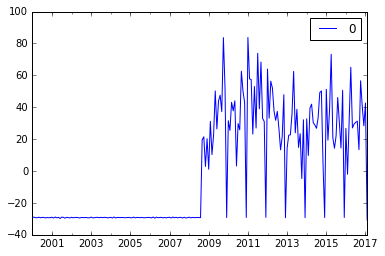

In [32]:
pd.DataFrame(components).plot()

## OLS for $\Lambda$ estimation

In [33]:
data.head()

,BZIPTLYo Index,MPMIBRMA Index,BZUETOTN Index,BFOETTOD Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,BZEXTOT$ Index,BZTBBALY INDEX,BZBXPBCM INDEX,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCGTOT INDEX,BZEANSA INDEX,OEBRD002 INDEX
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,-0.478036,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,-2.040221,0.177541,NaN,NaN,0.012987,NaN,30.209536,8.185658,NaN,4.977727,NaN,NaN,NaN,0.012270
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,-1.514128,0.081076,NaN,NaN,0.006431,NaN,0.295222,10.539636,NaN,-1.282322,NaN,NaN,NaN,0.040961
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,-0.867501,-0.066910,NaN,NaN,-0.012903,NaN,-22.027991,-16.527297,NaN,-5.509884,NaN,NaN,NaN,0.000000
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,-4.605170,0.191253,1.140128,NaN,0.022473,NaN,27.292925,12.355608,NaN,11.427068,NaN,NaN,NaN,0.040956


In [34]:
def cleanData(df1,df2):
    df = pd.concat([df1, df2],axis=1)
    return df.dropna(axis=0)

In [35]:
coefList = []
for s in data.columns:
    clean = cleanData(data[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])
for s in dataQ.columns:
    clean = cleanData(dataQ[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])    

In [36]:
lambda0 = pd.DataFrame(coefList)

## AR for $A$ estimation

In [37]:
A0 = coefList.append(sm.tsa.ARMA(components.dropna(),(1,0)).fit().params[1])


# Estimation With Initial Values

In [38]:
# Z0 = Z
# Z0[0] = lambda0
# Z0.iloc[-1,1] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,2] = 3 * Z0.iloc[-1,0]
# Z0.iloc[-1,3] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,4] = 1 * Z0.iloc[-1,0]

# Z0 = Z0.apply(pd.to_numeric,axis=1)
# Z0 = Z0.apply(pd.to_numeric,axis=0)

In [39]:
#  Spent a lot of time struggling here. 
# the size of the Z0 is actually the size of the non fixed parameters
Z0 = lambda0
Z0 = Z0.apply(pd.to_numeric,axis=1)
Z0 = Z0.apply(pd.to_numeric,axis=0)
Z0

,0
0,1.780918e-04
1,-2.087044e-04
2,2.195393e-04
3,7.391351e-05
4,6.316451e-04
5,-1.548003e-02
6,-2.148025e-03
7,-4.882428e-04
8,2.869769e-04
9,-1.127292e-02


In [40]:
Z0i = Z0.as_matrix().T.flatten()

In [44]:
print(dt.datetime.now())

2017-02-07 18:25:39.230110


In [ ]:
%%R -i Zi,Bi,yi,Z,Qi,m,n,Z0i


Zi=matrix(Zi,n,m)
Z0i=matrix(Z0i,n,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)


print(dim(Z0i))
print(dim(Zi))
print(dim(Bi))
print(dim(Qi))

print("START")

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero"
               ,U="zero"
               ,R="diagonal and unequal")


inits = list(Z=Z0i)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=1500,
                                                conv.test.slope.tol=0.3,
                                                abstol=0.5))
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit=30))
# kemfit = MARSS(yi, model=model.gen,inits=inits,fit=TRUE)
# kemfit = MARSS(yi, model=model.gen,fit=FALSE)

# print(kemfit$par$Z)
# states = kemfit$states
states = print(kemfit, what="model")
# message(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)
# message("porra")
# states=""
# cat("teste")

In [ ]:
print(dt.datetime.now())

In [ ]:
varModel = sm.tsa.VAR(components)
results = varModel.fit(1)
results.summary()

In [ ]:
initialB = pd.DataFrame(results.coefs[0])

## Response Variable

In [ ]:
gdp = pd.read_excel('GDP.xlsx',dayFirst=True)
gdp.set_index("Date", inplace=True)
gdp["GDP"] = np.log(gdp["GDP"]) - np.log(gdp["GDP"].shift(1))

# Balanced Panel

In [ ]:
balancedIndex = ~data.isnull().any(axis=1)
data[balancedIndex]

In [ ]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(data[balancedIndex])
components = pd.DataFrame(components)
components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

## MARSS R-Package

In [ ]:
balancedPanel = data[balancedIndex].transpose().as_matrix()
initial = components.transpose().as_matrix()

zs = []
for i in range(0,26):
    zs.append('z'+str(i))

In [ ]:
%%R -i balancedPanel,zs,initial -o states

# class(meas)

Z="unconstrained"
# B="diagonal and unequal"
# B="identity"
B="unconstrained"
# x0=matrix(c("pi1"),1,1)
# x0=matrix(c("pi1","pi2"),2,1)

Z=matrix(list("z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13"),13,1)
# Z=matrix(zs,13,2)

x0="zero"
x0=initial

model.gen=list(Z=Z,B=B,A="zero",x0="zero",U="zero")
# model.gen=list(Z=Z,B=B,x0=x0,A="zero")
kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001))
states = kemfit$states
# print(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
# print(kemfit$par$Z)

In [ ]:
factor = pd.DataFrame(states).transpose().set_index(data[balancedIndex].index)
factor.plot()

In [ ]:
gdp[balancedIndex].plot()

# OLS - Nowcast

In [ ]:
factor = factor.rolling(window=3).sum()
olsSample = gdp.join(factor, how="inner")
gdpComp = olsSample[0]

In [ ]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

The model is not a good fit. We believe that could be due to the lack of specification of initial value for the parameters. Thus we will try do find initial value for the parameters running a VAR on PCA components, as in Banbura et al. 2013

# PCA to retrieve factors from balanced panel

In [ ]:
n_components=5
pca = PCA(n_components=n_components)
components = pca.fit_transform(data[balancedIndex])
components = pd.DataFrame(components)
components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

In [ ]:
sum(pca.explained_variance_ratio_)

In [ ]:
pd.DataFrame(components).plot()

# Initial Parameters Estimation 
## VAR - for B-Matrix Estimation

In [ ]:
varModel = sm.tsa.VAR(components)
results = varModel.fit(1)
results.summary()

In [ ]:
initialB = pd.DataFrame(results.coefs[0])

## OLS For Z-Matrix estimation

In [ ]:
results = sm.OLS(data[balancedIndex]['ConsumerConfidence'], components).fit()
results.params

In [ ]:
dfList = []
for col in data[balancedIndex].columns:
    results = sm.OLS(data[balancedIndex][col], components).fit()
    dfList.append(results.params)

initialZ = pd.concat(dfList,axis=1).transpose()
initialZ

# Re-Estimation of Factor Model by EM Algo

In [ ]:
initialB.shape

In [ ]:
initialZ = np.reshape(initialZ.stack().as_matrix(),(65,1))
initialB = np.reshape(initialB.stack().as_matrix(),(25,1))
print(initialZ.shape)
print(initialB.shape)

In [ ]:
numberOfFactors = 5
zs = []
for i in range(0,13*numberOfFactors):
    zs.append('z'+str(i))
    


In [ ]:
%%R -i balancedPanel,zs,initialB,initialZ,numberOfFactors -o states

# class(meas)
print(dim(initialZ))
Z="unconstrained"
# B="diagonal and unequal"
# B="identity"
B="unconstrained"
# x0=matrix(c("pi1"),1,1)
# x0=matrix(c("pi1","pi2"),2,1)

# Z=matrix(list("z1","z2","z3","z4","z5","z6","z7","z8","z9","z10","z11","z12","z13"),13,1)
Z=matrix(zs,13,numberOfFactors)
# print(Z)
# print(numberOfFactors)
inits = list(Z=initialZ, B=initialB)

x0="zero"
x0=initial

model.gen=list(Z=Z,B=B,A="zero",x0="zero",U="zero")
# model.gen=list(Z=Z,B=B,x0=x0,A="zero")
# kemfit = MARSS(balancedPanel, model=model.gen)
# kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001))
# kemfit = MARSS(balancedPanel, model=model.gen,control=list(conv.test.slope.tol=0.00001,abstol=0.00001),inits=inits)
kemfit = MARSS(balancedPanel, model=model.gen,inits=inits)
states = kemfit$states
# print(kemfit, what="model")
# print(kemfit, what="start")
# print(kemfit, what="states")
# print(kemfit, what="ytT")
# print(kemfit, what="states.se")
# print(kemfit, what="kfs")
print(dim(kemfit$par$Z))

In [ ]:
factor = pd.DataFrame(states).transpose().set_index(data[balancedIndex].index)
factor.plot()

In [ ]:
gdp[balancedIndex].plot()

# OLS - Nowcast

In [ ]:
# factor = factor.rolling(window=3).sum()
olsSample = gdp.join(factor, how="inner")
gdpComp = olsSample[[0,1,2,3,4]]

In [ ]:
gdpComp.head()

In [ ]:
# X = sm.add_constant(gdpComp)
X = gdpComp
model = sm.OLS(olsSample["GDP"],X)
results = model.fit()
results.params
print(results.summary())

Next Steps:

* Compare PCA Factors to Smoothed Factors
* Compare Predicted GDP to actual